In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [3]:
from helpers_thresholds import *

In [7]:
from load_data_and_augmentations import*

In [8]:
plt.rcParams['figure.figsize'] = (20,12)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 24}
plt.rc('font', **font)

In [21]:
tensor_transform = get_tensor_transform('ImageNet', False)
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/centre_Ch2/'
df = pd.read_csv('./important_csvs/more_balanced_dataset/big_stratified_new.csv')

bs = 1
seq_length = 50
df_valid = get_df(df, 50, False, True, False)
class_image_paths, end_idx, idx_label= get_indices(df_valid, root_dir)
indices, labels = get_final_indices_valid(idx_label, end_idx, 'overlap', set_step=25, seq_length=50, per_label=True)
valid_loader, valid_dataset = get_loader_new(50, bs, indices, class_image_paths, valid_temp_transform,
                                             valid_spat_transform, tensor_transform, False, False, True, 1)

df_test = get_df(df, 50, False, False, True)
class_image_paths, end_idx, idx_label = get_indices(df_test, root_dir)
indices, labels = get_final_indices_valid(idx_label, end_idx, 'overlap', set_step=25, seq_length=50, per_label=True)
test_loader, test_dataset = get_loader_new(50, bs, indices, class_image_paths, valid_temp_transform, 
                                            valid_spat_transform, tensor_transform, False, False, True, 1)

In [22]:
torch.cuda.empty_cache()

In [23]:
load = True
if load:
    checkpoint = torch.load('/media/scratch/astamoulakatos/saved-resnet-models/thirdnew/best-checkpoint-011epoch.pth')
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('loading pretrained freezed model!')

loading pretrained freezed model!


In [24]:
inputs, classes = next(iter(valid_loader))

In [25]:
inputs.shape

torch.Size([1, 3, 16, 576, 704])

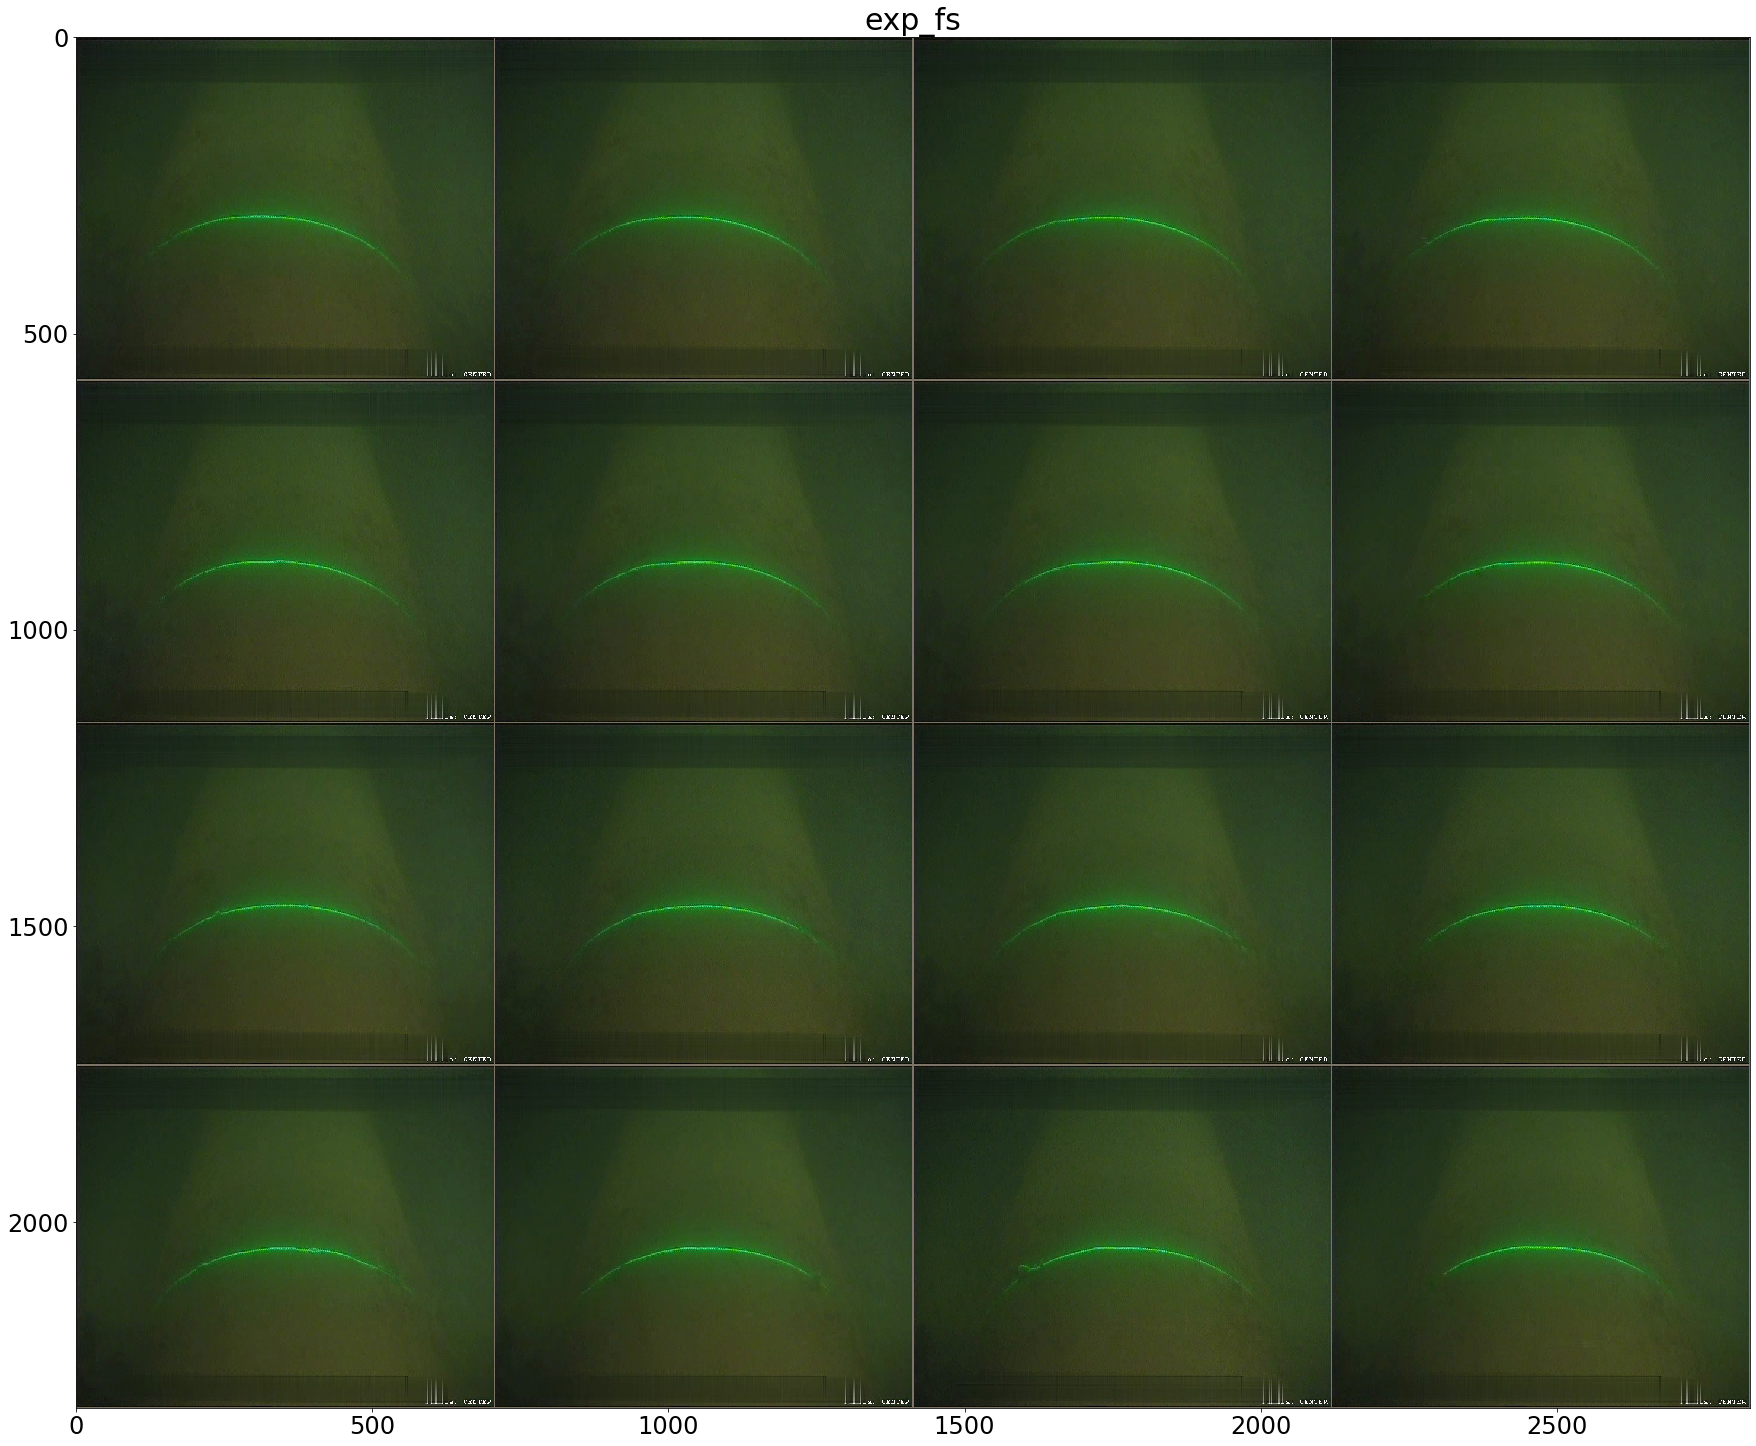

In [26]:
show_batch(valid_loader, 1, True, 2)

In [27]:
inputs.shape

torch.Size([1, 3, 16, 576, 704])

In [28]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output , _ = resnet(X)
        y = y.detach().cpu()
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu()
        mean_preds = torch.mean(preds, dim=0)
        y_pred.append(mean_preds)
        y_true.append(y)
        


In [29]:
y_pred

[tensor([0.9598, 0.0408, 0.0721, 0.0925, 0.9115]),
 tensor([0.0167, 0.9833, 0.2119, 0.2001, 0.0456]),
 tensor([0.9228, 0.0755, 0.0689, 0.1780, 0.9209]),
 tensor([0.1318, 0.8709, 0.2405, 0.1466, 0.0505]),
 tensor([0.9420, 0.0573, 0.1918, 0.9323, 0.0477]),
 tensor([0.9207, 0.0745, 0.2493, 0.1016, 0.4615]),
 tensor([0.9295, 0.0694, 0.0567, 0.1518, 0.9031]),
 tensor([0.9704, 0.0289, 0.0828, 0.4610, 0.0532]),
 tensor([0.6905, 0.3026, 0.3959, 0.3877, 0.0446]),
 tensor([0.9389, 0.0618, 0.2950, 0.0651, 0.0389]),
 tensor([0.9289, 0.0713, 0.0601, 0.1612, 0.9014]),
 tensor([0.8944, 0.1011, 0.0548, 0.7645, 0.0513]),
 tensor([0.9538, 0.0481, 0.0766, 0.1155, 0.9597]),
 tensor([0.1704, 0.8339, 0.1003, 0.3681, 0.0408]),
 tensor([0.9276, 0.0763, 0.9834, 0.0840, 0.0526]),
 tensor([0.1427, 0.8586, 0.0725, 0.2419, 0.0301]),
 tensor([0.9507, 0.0456, 0.1708, 0.1615, 0.5071]),
 tensor([0.9258, 0.0704, 0.8243, 0.2571, 0.0514]),
 tensor([0.9272, 0.0749, 0.8453, 0.2644, 0.0574]),
 tensor([0.0547, 0.9478, 0.2206

In [30]:
y_true

[tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 1., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 1., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor(

In [31]:
y_tr = np.vstack([tensor.__array__() for tensor in y_true])

In [32]:
y_pr = np.vstack([tensor.__array__() for tensor in y_pred]) 

In [33]:
y_tr

array([[1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.]], dtype=float32)

In [34]:
y_pr

array([[0.959824  , 0.04082122, 0.07213616, 0.09245515, 0.91153264],
       [0.01672584, 0.983307  , 0.21194714, 0.20011379, 0.04560738],
       [0.9228305 , 0.07552558, 0.06894688, 0.17804363, 0.9208733 ],
       ...,
       [0.390051  , 0.6005058 , 0.11845581, 0.07566419, 0.0453319 ],
       [0.9572415 , 0.04020708, 0.14470492, 0.10830703, 0.948302  ],
       [0.93399   , 0.06857893, 0.11998261, 0.2020313 , 0.9749022 ]],
      dtype=float32)

In [35]:
from helpers_thresholds import *

In [36]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

0.9805097451274363 0.9732142857142857 0.9768483943241225
Optimal  Exposure  Threshold =  0.6244197

0.8867924528301887 0.9155844155844156 0.9009584664536741
Optimal  Burial  Threshold =  0.37374228

0.8908045977011494 0.8516483516483516 0.8707865168539326
Optimal  Field Joint  Threshold =  0.6038673

0.7575757575757576 0.8426966292134831 0.7978723404255319
Optimal  Anode  Threshold =  0.6775375

1.0 1.0 1.0
Optimal  Free Span  Threshold =  0.423017



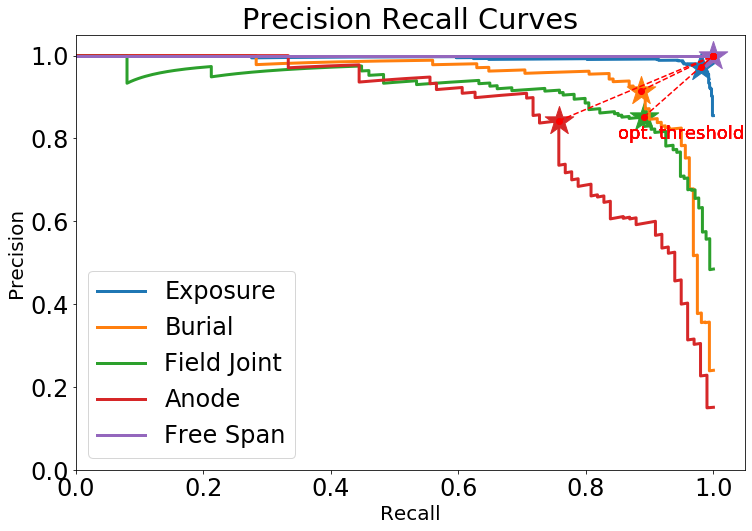

In [38]:
plot_pr_curves(0.0, y_tr, y_pr, classes, '_2d_thirdnew_rolling_avg')

In [39]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [40]:
thresholds

{'Exposure': 0.6244197,
 'Burial': 0.37374228,
 'Field Joint': 0.6038673,
 'Anode': 0.6775375,
 'Free Span': 0.423017}

In [41]:
df_thresholds = pd.DataFrame({'Threshold': thresholds}).T
df_thresholds

,Anode,Burial,Exposure,Field Joint,Free Span
Threshold,0.677538,0.373742,0.62442,0.603867,0.423017


# Table 1

In [42]:
print(df_thresholds.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{lrrrrr}
\toprule
{} &  Anode &  Burial &  Exposure &  Field Joint &  Free Span \\
\midrule
Threshold &  0.677 &   0.373 &     0.624 &        0.603 &      0.423 \\
\bottomrule
\end{tabular}



## validation set

In [43]:
result_valid = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [44]:
result_valid

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.624420,0.962470,0.973214,0.980510,0.976848,141.0,18.0,13.0,654.0
1,Burial,0.373742,0.962470,0.915584,0.886792,0.900958,654.0,13.0,18.0,141.0
2,Field Joint,0.603867,0.944310,0.851648,0.890805,0.870787,625.0,27.0,19.0,155.0
3,Anode,0.677538,0.953995,0.842697,0.757576,0.797872,713.0,14.0,24.0,75.0
4,Free Span,0.423017,1.000000,1.000000,1.000000,1.000000,586.0,0.0,0.0,240.0
5,Aggregate,NaN,0.870460,0.945725,0.944735,0.944971,NaN,NaN,NaN,NaN


In [45]:
print(result_valid.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &      tn &     fp &     fn &      tp \\
\midrule
0 &     Exposure &      0.624 &                 0.962 &      0.973 &   0.980 &     0.976 & 141.000 & 18.000 & 13.000 & 654.000 \\
1 &       Burial &      0.373 &                 0.962 &      0.915 &   0.886 &     0.900 & 654.000 & 13.000 & 18.000 & 141.000 \\
2 &  Field Joint &      0.603 &                 0.944 &      0.851 &   0.890 &     0.870 & 625.000 & 27.000 & 19.000 & 155.000 \\
3 &        Anode &      0.677 &                 0.953 &      0.842 &   0.757 &     0.797 & 713.000 & 14.000 & 24.000 &  75.000 \\
4 &    Free Span &      0.423 &                 1.000 &      1.000 &   1.000 &     1.000 & 586.000 &  0.000 &  0.000 & 240.000 \\
5 &    Aggregate &        nan &                 0.870 &      0.945 &   0.944 &     0.944 &     nan &    nan &    nan &     nan \\
\bottomrule
\end{tabular}



In [46]:
acc, f1 = compute_label_metrics(y_tr, y_pr, 0.5, classes)

In [47]:
acc

array([0.96246973, 0.96246973, 0.94430993, 0.95399516, 1.        ])

In [48]:
f1

array([0.97684839, 0.90095847, 0.87078652, 0.79787234, 1.        ])

## test set

In [49]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output , _ = resnet(X)
        y = y.detach().cpu()
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu()
        mean_preds = torch.mean(preds, dim=0)
        y_pred.append(mean_preds)
        y_true.append(y)
        


In [50]:
y_tr = np.vstack([tensor.__array__() for tensor in y_true])

In [51]:
y_pr = np.vstack([tensor.__array__() for tensor in y_pred]) 

In [52]:
result_test = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [53]:
result_test

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.624420,0.928144,0.952663,0.958333,0.955490,131.0,32.0,28.0,644.0
1,Burial,0.373742,0.929341,0.825000,0.809816,0.817337,644.0,28.0,31.0,132.0
2,Field Joint,0.603867,0.965269,0.912568,0.927778,0.920110,639.0,16.0,13.0,167.0
3,Anode,0.677538,0.959281,0.840426,0.806122,0.822917,722.0,15.0,19.0,79.0
4,Free Span,0.423017,0.998802,1.000000,0.995833,0.997912,595.0,0.0,1.0,239.0
5,Aggregate,NaN,0.859880,0.932216,0.932003,0.932062,NaN,NaN,NaN,NaN


In [54]:
print(result_test.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &      tn &     fp &     fn &      tp \\
\midrule
0 &     Exposure &      0.624 &                 0.928 &      0.952 &   0.958 &     0.955 & 131.000 & 32.000 & 28.000 & 644.000 \\
1 &       Burial &      0.373 &                 0.929 &      0.825 &   0.809 &     0.817 & 644.000 & 28.000 & 31.000 & 132.000 \\
2 &  Field Joint &      0.603 &                 0.965 &      0.912 &   0.927 &     0.920 & 639.000 & 16.000 & 13.000 & 167.000 \\
3 &        Anode &      0.677 &                 0.959 &      0.840 &   0.806 &     0.822 & 722.000 & 15.000 & 19.000 &  79.000 \\
4 &    Free Span &      0.423 &                 0.998 &      1.000 &   0.995 &     0.997 & 595.000 &  0.000 &  1.000 & 239.000 \\
5 &    Aggregate &        nan &                 0.859 &      0.932 &   0.932 &     0.932 &     nan &    nan &    nan &     nan \\
\bottomrule
\end{tabular}



In [56]:
precision, recall, f1, _ = precision_recall_fscore_support(y_tr, y_pr)